## **Imports**

In [ ]:
""" Import Statements """

# Classics
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import squarify

import re
import spacy
from spacy.tokenizer import Tokenizer
from collections import Counter

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors

In [ ]:
df = pd.read_csv('../app/data/csv/cannabis.csv')

#change from combined_cannabis.csv to cannabis.csv

In [ ]:
print('Shape:', df.shape)
df.head()

Shape: (2155, 8)


,_id,Name,Type,Rating,Effects,Description,Flavors,Nearest
0,0,Kelly Hill Gold,Indica,5.0,"Happy,Energetic,Euphoric,Talkative,Aroused",Cultivated by Joseph Arthur Botanicals in Colo...,"Pepper,Earthy,Coffee","992,897,439,184,1877"
1,1,Spyder Mon,Hybrid,5.0,"Uplifted,Creative,Focused,Happy,Relaxed",Spyder Mon is an uplifting CBD strain with a g...,"Citrus,Earthy,Sweet","218,157,1627,223,742"
2,2,Mochi,Hybrid,5.0,"Sleepy,Happy,Hungry,Relaxed,Tingly",Mochi by Sherbinski is another strain that lea...,"Pungent,Minty,Flowery","614,457,208,705,130"
3,3,Molokai Purpz,Indica,5.0,"Aroused,Creative,Euphoric,Relaxed,Sleepy",Moloka'i Purpz is a luscious Hawaiian landrace...,"Berry,Grape,Sweet","1478,562,1063,50,390"
4,4,Monolith,Indica,5.0,"Relaxed,Sleepy,Tingly,Euphoric,Focused",Monolith is an indica-dominant strain with Afg...,"Pungent,Earthy,Pine","1397,862,1094,214,141"


## **Data Cleaning**

In [ ]:
df.isnull().sum()

_id            0
Name           0
Type           0
Rating         0
Effects        0
Description    0
Flavors        0
Nearest        0
dtype: int64

## **Tokenizing**

### Creating a corpus

In [ ]:
#Combining features to create a strain profile
df['strain_profile'] = df['Type'] + ',' + df['Effects'] + ',' + df['Description']

In [ ]:
#Doing some manual cleaning 

#Lowercase text
df['strain_profile'] = df['strain_profile'].apply(lambda x: x.lower())

#Remove symbols
df['strain_profile'] = df['strain_profile'].apply(lambda x: re.sub('[^a-zA-Z 0-9]', ' ', x))

In [ ]:
df.head()

,_id,Name,Type,Rating,Effects,Description,Flavors,Nearest,strain_profile
0,0,Kelly Hill Gold,Indica,5.0,"Happy,Energetic,Euphoric,Talkative,Aroused",Cultivated by Joseph Arthur Botanicals in Colo...,"Pepper,Earthy,Coffee","992,897,439,184,1877",indica happy energetic euphoric talkative arou...
1,1,Spyder Mon,Hybrid,5.0,"Uplifted,Creative,Focused,Happy,Relaxed",Spyder Mon is an uplifting CBD strain with a g...,"Citrus,Earthy,Sweet","218,157,1627,223,742",hybrid uplifted creative focused happy relaxed...
2,2,Mochi,Hybrid,5.0,"Sleepy,Happy,Hungry,Relaxed,Tingly",Mochi by Sherbinski is another strain that lea...,"Pungent,Minty,Flowery","614,457,208,705,130",hybrid sleepy happy hungry relaxed tingly moch...
3,3,Molokai Purpz,Indica,5.0,"Aroused,Creative,Euphoric,Relaxed,Sleepy",Moloka'i Purpz is a luscious Hawaiian landrace...,"Berry,Grape,Sweet","1478,562,1063,50,390",indica aroused creative euphoric relaxed sleep...
4,4,Monolith,Indica,5.0,"Relaxed,Sleepy,Tingly,Euphoric,Focused",Monolith is an indica-dominant strain with Afg...,"Pungent,Earthy,Pine","1397,862,1094,214,141",indica relaxed sleepy tingly euphoric focused ...


### spaCy s

In [ ]:
nlp = spacy.load("en_core_web_lg")

In [ ]:
STOP_WORDS = nlp.Defaults.stop_words.union({"$", '-', '', ' ',
                                            'bred','breed', 'breeds','call', 'calls',
                                            'combine', 'combines','consumer', 'contains','containing',
                                            "don't", 'effect', 'effects','especially','explanations',
                                            'flavor', 'flavors','flower','give', 'gives','got',  'high',
                                            'i', "i'm", "i've",'including','it.', "it's", 
                                            'like', 'match', 'matches','making',
                                            'offer', 'offers','pack', 'packs','price', 'probably',
                                            'produce', 'produces', 'really',
                                            'refers', 'report', 'reports', "'s", 's',
                                            'seed', 'seeds','showing', 
                                            'smell','start', 'started', 'stem', 'stems',
                                            'strain', 'strains','supposedly',
                                            'technique', 'techniques','tend', 'tends',
                                            'unavailable', 'unkown', 'user', 'users', 'utlizing',
                                            'weed', 'week', None})

In [ ]:
def tokenize(text):
  doc = nlp(text) #casting as text
  return [token.lemma_.strip() for token in doc if not token.is_stop and not token.is_punct]

In [ ]:
df['tokens'] = df['strain_profile'].apply(tokenize)

In [ ]:
df['tokens']

0       [indica, happy, energetic, euphoric, talkative...
1       [hybrid, uplifted, creative, focus, happy, rel...
2       [hybrid, sleepy, happy, hungry, relaxed, tingl...
3       [indica, arouse, creative, euphoric, relaxed, ...
4       [indica, relax, sleepy, tingly, euphoric, focu...
                              ...                        
2150    [indica, uplifted, focus, sleepy, relaxed, tin...
2151    [hybrid, happy, white, strawberry, flavorful, ...
2152    [hybrid, talkative, happy, energetic, tingly, ...
2153    [hybrid, relax, focus, uplifted, creative, hap...
2154    [sativa, giggly, uplifted, creative, happy, sl...
Name: tokens, Length: 2155, dtype: object

In [ ]:
# Gut check

# Object from Base Python

word_counts = Counter()

# Update it based on a split of each of our documents
df["tokens"].apply(lambda x: word_counts.update(x))

# Print out the 20 most common words
word_counts.most_common(20)

[('', 16191),
 ('strain', 2759),
 ('hybrid', 2331),
 ('indica', 2003),
 ('happy', 1922),
 ('euphoric', 1745),
 ('effect', 1475),
 ('sativa', 1469),
 ('uplifted', 1358),
 ('s', 1271),
 ('relaxed', 1164),
 ('cross', 1031),
 ('og', 993),
 ('kush', 987),
 ('aroma', 919),
 ('dominant', 892),
 ('relax', 875),
 ('creative', 844),
 ('sweet', 787),
 ('bud', 737)]

In [ ]:
def count(docs):
        word_counts = Counter()
        appears_in = Counter()
        total_docs = len(docs)

        for doc in docs:
            word_counts.update(doc)
            appears_in.update(set(doc))

        temp = zip(word_counts.keys(), word_counts.values())
        wc = pd.DataFrame(temp, columns = ['word', 'count'])

        wc['rank'] = wc['count'].rank(method='first', ascending=False)
        total = wc['count'].sum()

        wc['pct_total'] = wc['count'].apply(lambda x: x / total)
        
        wc = wc.sort_values(by='rank')
        wc['cul_pct_total'] = wc['pct_total'].cumsum()

        t2 = zip(appears_in.keys(), appears_in.values())
        ac = pd.DataFrame(t2, columns=['word', 'appears_in'])
        wc = ac.merge(wc, on='word')

        wc['appears_in_pct'] = wc['appears_in'].apply(lambda x: x / total_docs)
        
        return wc.sort_values(by='rank')

In [ ]:
wc = count(df["tokens"])
wc.head(50)

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
0,,2133,16191,1.0,0.123846,0.123846,0.989791
6,strain,1694,2759,2.0,0.021104,0.144950,0.786079
99,hybrid,1309,2331,3.0,0.017830,0.162780,0.607425
13,indica,1088,2003,4.0,0.015321,0.178101,0.504872
34,happy,1821,1922,5.0,0.014701,0.192802,0.845012
33,euphoric,1609,1745,6.0,0.013348,0.206150,0.746636
1,effect,1217,1475,7.0,0.011282,0.217432,0.564733
272,sativa,838,1469,8.0,0.011236,0.228669,0.388863
92,uplifted,1342,1358,9.0,0.010387,0.239056,0.622738
58,s,895,1271,10.0,0.009722,0.248778,0.415313


### Visualize tokens

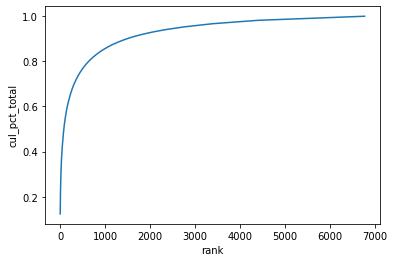

In [ ]:
sns.lineplot(x='rank', y='cul_pct_total', data=wc);

In [ ]:
# Percentage of the the top 200 words

wc[wc['rank'] <= 200]['cul_pct_total'].max()

0.6342142502007847

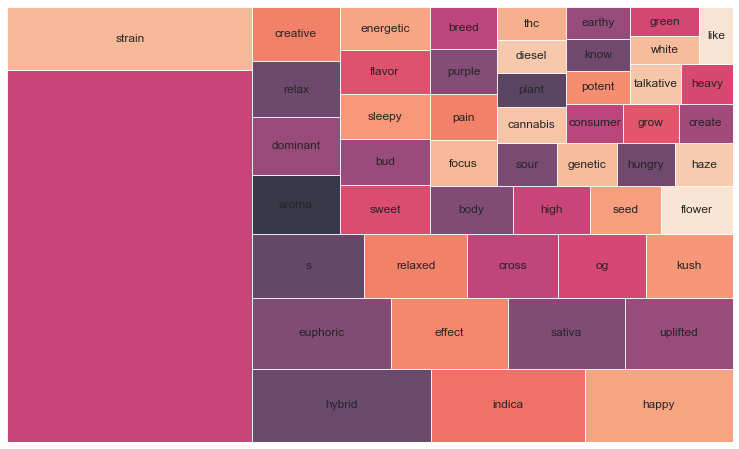

In [ ]:
sns.set(rc={'figure.figsize':(13,8)})

wc_top20 = wc[wc['rank'] <= 50]

squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()

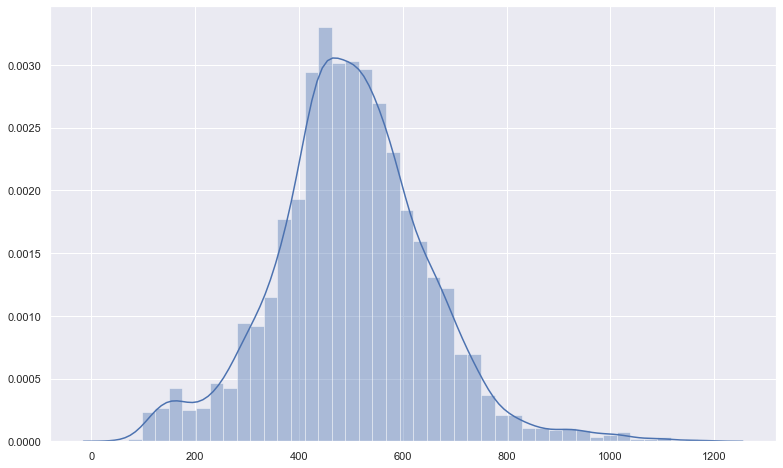

In [ ]:
# Visualize document length distribution of Description data set

doc_len = [len(doc) for doc in df['strain_profile']]

sns.distplot(doc_len);

In [ ]:
df = df.drop(['strain_profile', 'tokens'], axis=1)

In [ ]:
df.head()

,_id,Name,Type,Rating,Effects,Description,Flavors,Nearest
0,0,Kelly Hill Gold,Indica,5.0,"Happy,Energetic,Euphoric,Talkative,Aroused",Cultivated by Joseph Arthur Botanicals in Colo...,"Pepper,Earthy,Coffee","992,897,439,184,1877"
1,1,Spyder Mon,Hybrid,5.0,"Uplifted,Creative,Focused,Happy,Relaxed",Spyder Mon is an uplifting CBD strain with a g...,"Citrus,Earthy,Sweet","218,157,1627,223,742"
2,2,Mochi,Hybrid,5.0,"Sleepy,Happy,Hungry,Relaxed,Tingly",Mochi by Sherbinski is another strain that lea...,"Pungent,Minty,Flowery","614,457,208,705,130"
3,3,Molokai Purpz,Indica,5.0,"Aroused,Creative,Euphoric,Relaxed,Sleepy",Moloka'i Purpz is a luscious Hawaiian landrace...,"Berry,Grape,Sweet","1478,562,1063,50,390"
4,4,Monolith,Indica,5.0,"Relaxed,Sleepy,Tingly,Euphoric,Focused",Monolith is an indica-dominant strain with Afg...,"Pungent,Earthy,Pine","1397,862,1094,214,141"


# ML Model

## Vectorization

### TFIDF

In [ ]:
# Instantiate vectorizer object
tfidf = TfidfVectorizer(stop_words='english', 
                        ngram_range=(1,3),
                        max_df=.97,
                        min_df=3,
                        tokenizer=tokenize,
                        max_features = 5000)

# Create a vocabulary and get word counts per document
dtm = tfidf.fit_transform(df['Type'] + df['Description'] + df['Effects'] + df['Flavors']) # Similiar to fit_predict

# Print word counts

# Get feature names to use as dataframe column headers
dtm = pd.DataFrame(dtm.todense(), columns=tfidf.get_feature_names())

# View Feature Matrix as DataFrame
dtm.head()

,1,1 hybrid,10,10 11,10 11 week,10 week,10 week flower,10 week produce,10 weeks.relaxed,100,...,yield potency,yield sweet,yield thc,yielder,yields.happy,yoda,zest,zesty,zesty lemon,zombie
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Nearest Neighbors model

In [ ]:
nn = NearestNeighbors(n_neighbors=5, algorithm = "kd_tree")
nn.fit(dtm)

NearestNeighbors(algorithm='kd_tree', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [ ]:
user_input = ['I am suffering from headaches. Looking for a sweet flavor and being uplifted and energetic.']

In [ ]:
user_dense = tfidf.transform(user_input)
nn_user = nn.kneighbors(user_dense.todense())

In [ ]:
nn_user

(array([[1.29362567, 1.29553905, 1.30351884, 1.31312138, 1.31513443]]),
 array([[1846, 1354,  596, 1266, 1312]]))

In [ ]:
df.iloc[1846]

_id                                                         1846
Name                                                   Fire Haze
Type                                                      Sativa
Rating                                                      3.18
Effects                  Euphoric,Focused,Happy,Relaxed,Uplifted
Description    Fire Haze is a true sativa. Great for consumer...
Flavors                                       Sweet,Berry,Earthy
Nearest                                  1775,1137,1052,1406,382
Name: 1846, dtype: object

In [ ]:
df.iloc[1354]

_id                                                         1354
Name                                                  Lemon Jack
Type                                                      Sativa
Rating                                                      3.64
Effects                Focused,Energetic,Happy,Uplifted,Creative
Description    While Lemon Jack has yet to earn the reputatio...
Flavors                                       Lemon,Citrus,Sweet
Nearest                                   1895,425,824,2122,1707
Name: 1354, dtype: object

In [ ]:
df.iloc[596]

_id                                                          596
Name                                                   Glue Tech
Type                                                      Hybrid
Rating                                                      4.09
Effects                   Happy,Relaxed,Hungry,Uplifted,Euphoric
Description    Glue Tech is a functional indica that shows it...
Flavors                                       Earthy,Sweet,Berry
Nearest                                       205,161,354,420,18
Name: 596, dtype: object

In [ ]:
df.iloc[1266]

_id                                                         1266
Name                                           Cinderellas Dream
Type                                                      Hybrid
Rating                                                      3.64
Effects             Euphoric,Uplifted,Energetic,Focused,Creative
Description    Cinderella's Dream is a sativa-dominant hybrid...
Flavors                                      Pepper,Sweet,Citrus
Nearest                                   634,1133,1406,542,1287
Name: 1266, dtype: object

In [ ]:
df.iloc[1312]

_id                                                         1312
Name                                           Super Silver Haze
Type                                                      Sativa
Rating                                                      3.64
Effects                Happy,Uplifted,Energetic,Euphoric,Relaxed
Description    Super Silver Haze, bred by Green House Seeds, ...
Flavors                                      Citrus,Earthy,Sweet
Nearest                                  1813,1271,1874,689,1447
Name: 1312, dtype: object

# Functions

In [ ]:
# Create nearest neighbor function

def recommender(user_input):
    
    recommendations = nn.kneighbors(tfidf.transform([user_input]).todense())[1]    
    return recommendations



In [ ]:
recommender(user_input)

{'_id': 1846,
 'Name': 'Fire Haze',
 'Type': 'Sativa',
 'Rating': 3.18,
 'Effects': 'Euphoric,Focused,Happy,Relaxed,Uplifted',
 'Description': 'Fire Haze is a true sativa. Great for consumers who suffer from stress, anxiety, and headaches, this strain is mentally stimulating and upbeat. The effects of Fire Haze are felt most strongly in the head, providing consumers with focus and tension reduction in both the head and neck. Sociable and energizing, Fire Haze is a great daytime strain. It features a strong herbal scent and a musky, nutty taste. This may not be a good strain for those who suffer from acute pain, as it does not provide the same muscle-relaxing sensations that are found in indicas.',
 'Flavors': 'Sweet,Berry,Earthy',
 'Nearest': '1775,1137,1052,1406,382'}